# <center>license plate recognition.





import all the libraries & Requirements that we need when solving the project:

In [1]:
#requirements Before run install all pips
#pip install jedi>=0.10
#!pip install torch

In [2]:
# Libraries for handling tabular data
import pandas as pd
import numpy as np

# Libraries for visualization of graphs and images/
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Libraries for training models
import torch
from sklearn.model_selection import train_test_split

# Library for working with the operating system
import os
import glob

# Library for parsing XML files
import xml.etree.ElementTree as ET 

#Auxiliary bibilotheques
from tqdm.auto import tqdm
import shutil as sh

Next, check that we have a graphics accelerator available.

In [3]:
# Check if the graphics card is available to us
print(torch.cuda.is_available())
# Look at the name of the video card
#print(torch.cuda.get_device_name(0))

True


***Note:***

*If the result of the `cuda.is_available()` function is False, it means that you are not using a graphics card. Check that you have changed the accelerator in the Kaggle laptop settings.*

Let's set global variables with paths to the folders we need for convenience:

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
# Path to folder with dataset
DATASET_PATH = "/content/drive/MyDrive/Colab Notebooks/cars_number_plate"
# Path to the folder with annotations
ANNOTATIONS_PATH = os.path.join(DATASET_PATH, "annotations")
# Path to folder with images
IMAGES_PATH = os.path.join(DATASET_PATH, "images")

print(ANNOTATIONS_PATH)
print(IMAGES_PATH)

/content/drive/MyDrive/Colab Notebooks/cars_number_plate/annotations
/content/drive/MyDrive/Colab Notebooks/cars_number_plate/images


Image shape: (398, 530, 3)


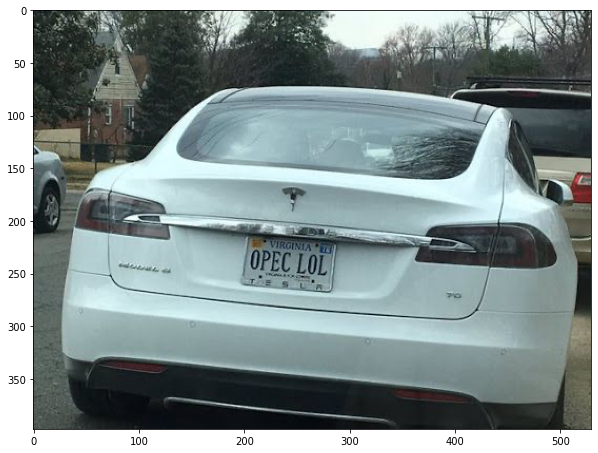

In [6]:
image_filename = 'Cars129.png'
image_path = os.path.join(IMAGES_PATH, image_filename)
# Read the image
img = plt.imread(image_path)
# Create a figure and a coordinate plane
fig, ax = plt.subplots(figsize=(10, 8))
# Display the image on the screen
ax.imshow(img);
# Display image size
print('Image shape: {}'.format(img.shape))

**Note:**

*When read by the matplotlib library, pixel intensity is measured from 0 to 1, where 1 corresponds to 255 for the standard image format.
You can verify this yourself by displaying the read image on the screen as an array:*

In [7]:
#print(img)

**Now** let's look at an example annotation for this image.

In [8]:
# Read one of the annotated files and look at the contents
with open(os.path.join(ANNOTATIONS_PATH, 'Cars129.xml')) as f:
    print(f.read())


<annotation>
    <folder>images</folder>
    <filename>Cars129.png</filename>
    <size>
        <width>530</width>
        <height>398</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>licence</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>204</xmin>
            <ymin>213</ymin>
            <xmax>282</xmax>
            <ymax>267</ymax>
        </bndbox>
    </object>
</annotation>


When using the PASCAL VOC format annotation, the following tags are specified:
* `<annotation>` - root title
    * `<folder>` - image folder
    * `<filename>` - file name
    * `<size>` - size information
        * `<width>` - width
        * `<height>` - height
        * `<depth>` - depth (number of channels)
    * `<segmented>` - this field contains information for segmentation. That is, do the images contain annotations of a non-linear (irregular) shape, usually called polygons (we don’t have those, all frames are rectangular, so the value is 0)
    * `<object>` - information for object detection
        * `<name>` is the name of the class (in our case, the license plate).
        * `<pose>` - sets the asymmetry or orientation of the image. By default, it is listed as Unspecified, which means that the image is not distorted.
        * `<truncated>` - indicates whether the object is fully or partially visible (can be 0 or 1 respectively)
        * `<occluded>` - information about the absorption of classes by each other (this is when inside the bounding box of class A, there is a bounding box of class B)
        * `<difficult>` - Indicates whether it is difficult to recognize the object in the image (can be 0 - easy or 1 - difficult).
        * `<bndbox>` are coordinates that define the location of an object (in our case, a car's license plate).
        These coordinates are contained in the child tags `<xmin>, <ymin>, <xmax>, <ymax>`. The annotation stores the coordinates of the top left and bottom right positions of the object.

Let's create a DataFrame for further convenience, in which we will store the following columns:
* `filename` - file name (without extension)
* `xmin`, `xmax` - minimum and maximum coordinates of the frame along the x axis
* `ymin`, `ymax` - the minimum and maximum coordinates of the frame along the y axis
* `width`, `height` - image width and height

To do this, we use the following code to parse XML files with annotations:

In [9]:
# Initialise the dictionary, then create a DataFrame based on it
df_dict = {
    "filename":[], "xmin":[], "ymin":[],   
    "xmax":[],"ymax":[], "name":[],    
    "width":[], "height":[],
}

# Create a loop on all annotations from 
for annotation in glob.glob(ANNOTATIONS_PATH+"/*.xml"):
    # Read the XML file with the annotation
    tree = ET.parse(annotation)
    # Find the tag corresponding to the file name
    filename = tree.find('filename').text
    # Create a loop through all elements of the XML file
    for elem in tree.iter():
        # Retrieve image size information from the annotation - width and height
        if 'size' in elem.tag:
            for attr in list(elem):
                if 'width' in attr.tag: 
                    width = int(round(float(attr.text)))
                if 'height' in attr.tag:
                    height = int(round(float(attr.text)))    
        # get the picture information - the class name and the bounding box coordinate information 
        if 'object' in elem.tag:
            for attr in list(elem):
                if 'name' in attr.tag:
                    name = attr.text                 
                    df_dict['name'] += [name]
                    df_dict['width'] += [width]
                    df_dict['height'] += [height] 
                    df_dict['filename'] += [filename]
                            
                if 'bndbox' in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                            df_dict['xmin'] += [xmin]
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            df_dict['ymin'] += [ymin]                                
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            df_dict['xmax'] += [xmax]                                
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            df_dict['ymax'] += [ymax]


After executing this code, we get the dictionary we need and convert it to a DataFrame:

In [10]:
df = pd.DataFrame(df_dict)
df.head()

,filename,xmin,ymin,xmax,ymax,name,width,height
0,Cars1.png,134,128,262,160,licence,400,248
1,Cars0.png,226,125,419,173,licence,500,268
2,Cars101.png,167,202,240,220,licence,400,300
3,Cars103.png,230,129,248,134,licence,400,196
4,Cars103.png,189,116,202,121,licence,400,196


Now it will be very convenient for us to analyse the characteristics of our dataset. Let's look at the number of records (annotations), unique number of images and unique classes in the data:

In [11]:
print('Data shape: {}'.format(df.shape))
print('Count of unique images: {}'.format(df['filename'].nunique()))
print('Count of classes: {}'.format(df['name'].unique()))


Data shape: (471, 8)
Count of unique images: 433
Count of classes: ['licence']


[204] [213] [78] [54]


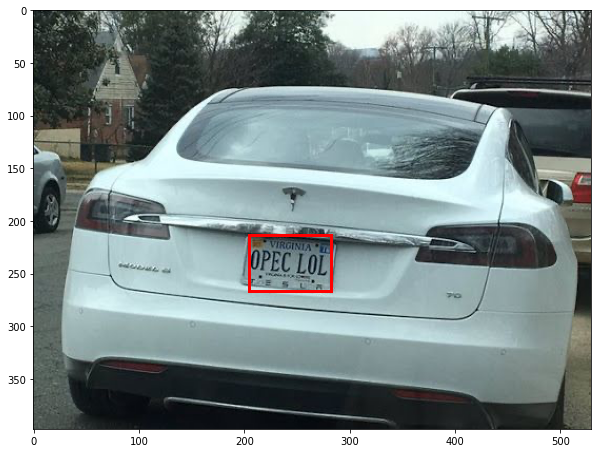

In [12]:
# Make a path to the file - /path/folder/image_name.png
image_filename = 'Cars129.png'
image_path = os.path.join(IMAGES_PATH, image_filename)
# read the image
img = plt.imread(image_path)
# create shape and coordinate plane
fig, ax = plt.subplots(figsize=(10, 8))
# print the image
ax.imshow(img);

# find the index of the image in the DataFrame
image_idx = df[df['filename'] == image_filename].index

# Find coordinates of the left bottom point
x_min = df.loc[image_idx, 'xmin'].values
y_min = df.loc[image_idx, 'ymin'].values
# find the width and height of the box
box_width = (df.loc[image_idx, 'xmax'] - df.loc[image_idx, 'xmin']).values
box_height = (df.loc[image_idx, 'ymax'] - df.loc[image_idx, 'ymin']).values
print(x_min, y_min, box_width, box_height)

# because there can be several boxes, we create a loop for all of them
for i in range(len(image_idx)):
    # build a rectangle
    rect = patches.Rectangle(
        (x_min[i], y_min[i]), # Coordinates of anchor point
        box_width[i], #width of the rectangle
        box_height[i], #height of the rectangle
        linewidth=3, #width of the line
        edgecolor='r', #color
        facecolor='none' #fill (none - none)
    )
    # superimpose rectangle on top of image
    ax.add_patch(rect);

In [13]:
def plot_bounding_box(image_folder, image_filename, df=df):
    # Create a full path to the image
    image_path = os.path.join(image_folder, image_filename)
    # read the image
    img = plt.imread(image_path)
    # create shape and coordinate plane
    fig, ax = plt.subplots(figsize=(10, 8))
    # print the image
    ax.imshow(img);

    # find the index of the image in the DataFrame
    image_idx = df[df['filename'] == image_filename].index

    # Find coordinates of the left bottom point
    x_min = df.loc[image_idx, 'xmin'].values
    y_min = df.loc[image_idx, 'ymin'].values
    # find the width and height of the box
    box_width = (df.loc[image_idx, 'xmax'] - df.loc[image_idx, 'xmin']).values
    box_height = (df.loc[image_idx, 'ymax'] - df.loc[image_idx, 'ymin']).values
    # because there can be several boxes, we loop through them all
    for i in range(len(image_idx)):
        # build a rectangle
        rect = patches.Rectangle(
            (x_min[i], y_min[i]), # Coordinates of anchor point
            box_width[i], #width of the rectangle
            box_height[i], #height of the rectangle
            linewidth=3, #width of the line
            edgecolor='r', #color
            facecolor='none' #fill (none - none)
        )
        # superimpose rectangle on top of image
        ax.add_patch(rect);

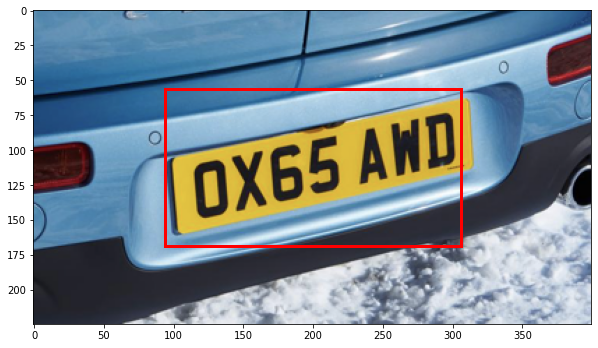

In [14]:
plot_bounding_box(image_folder=IMAGES_PATH, image_filename='Cars33.png', df=df)

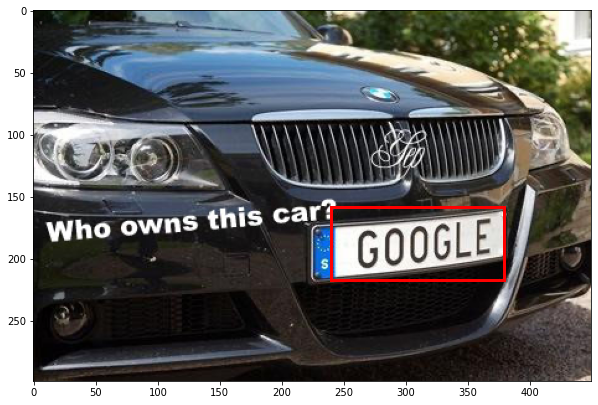

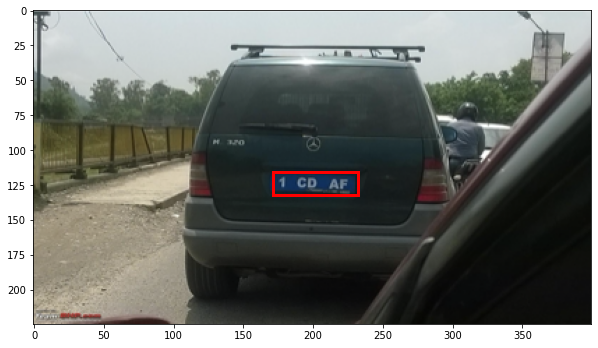

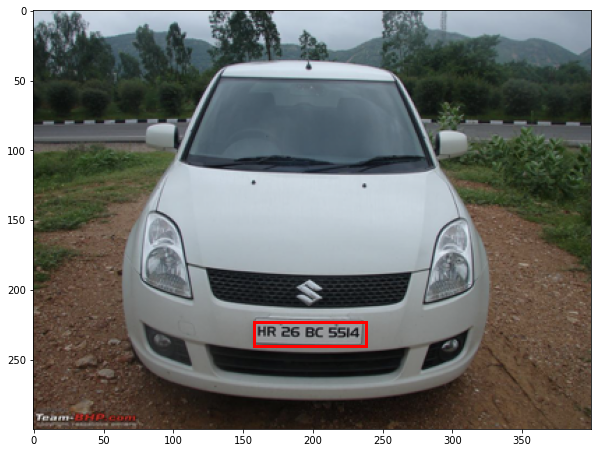

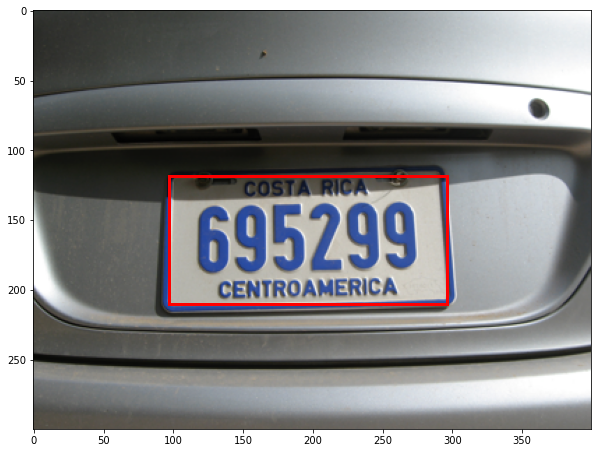

In [15]:
count = 4
for i in range(count):
    random_image_idx = np.random.choice(df.shape[0])
    image_filename = df.loc[random_image_idx, 'filename']
    plot_bounding_box(IMAGES_PATH, image_filename, df)

## Selecting the model and prepare the data

In the world of computer vision, for every task, be it classification, detection or image generation, there are specific solution methods (specific neural network architectures). However, for every neural network architecture there are dozens of implementations. Each implementation, in its turn, requires a certain format of input data to be used. 

So the preprocessing of input data depends on the architecture of the model and the implementation we choose.

## Selecting a model

In [16]:
DATA_PATH = "dataset/" # dataset root folder

LABELS_PATH = os.path.join(DATA_PATH, "labels") # Annotations folder
IMGS_PATH = os.path.join(DATA_PATH, "images") #Images folder

TRAIN_IMAGES_PATH = os.path.join(IMGS_PATH, "train") # Path to folder with training graphics
VAL_IMAGES_PATH = os.path.join(IMGS_PATH, "val") #Path to folder with validation images
TRAIN_LABELS_PATH = os.path.join(LABELS_PATH, "train") #Path to folder with training annotations
VAL_LABELS_PATH = os.path.join(LABELS_PATH, "val") #Path to folder with validation annotations

DATA_CONFIG_PATH = os.path.join(DATA_PATH, "dataset.yaml") #Path to data configuration file

print(TRAIN_IMAGES_PATH)
print(VAL_IMAGES_PATH)
print(TRAIN_LABELS_PATH)
print(VAL_LABELS_PATH)
print(DATA_CONFIG_PATH)

dataset/images/train
dataset/images/val
dataset/labels/train
dataset/labels/val
dataset/dataset.yaml


Now let's create the directories we need. To do this, use the [makedirs()](https://docs-python.ru/standart-library/modul-os-python/funktsija-makedirs-modulja-os/) function from the os module. Also, to ensure code reproducibility and avoid errors when restarting the notebook, we will check if the folders we create exist with the [path.exists()](https://docs.python.org/3/library/os.path.html) function from the same module.

In [17]:
import os

In [18]:
# Create a local folder in which to put images and annotations (if it does not already exist)
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)
    
# create a folder to store the training images (if it does not exist already)    
if not os.path.exists(TRAIN_IMAGES_PATH):
    os.makedirs(TRAIN_IMAGES_PATH)
# create a folder to store the training annotations for the objects (if it does not exist already)
if not os.path.exists(TRAIN_LABELS_PATH):
    os.makedirs(TRAIN_LABELS_PATH)
    
# create a folder to store validation images (if it does not already exist) 
if not os.path.exists(VAL_IMAGES_PATH):
    os.makedirs(VAL_IMAGES_PATH)
    
# create a folder to store validation annotations for objects (if it does not already exist)
if not os.path.exists(VAL_LABELS_PATH):
    os.makedirs(VAL_LABELS_PATH)

As a result of running this code, we should have a directory structure like the one we gave above. Let's check this with the Linux ls command:

In [19]:
!ls dataset
!ls dataset/images

!ls dataset/labels

images	labels
train  val
train  val


Finally, the final step in preparing the directory. Let's add a data configuration file, name it like in the example above - dataset.yaml, in it we will write all the paths we discussed above.

In [20]:
# Create the contents of the file
data_config = f'''
path: /content/drive/MyDrive/Colab Notebooks/cars_number_plate/
train: images/train
val: images/val
test:
names:
    0: licence
'''

# Open a writable file that contains the configuration of the paths from which the training data will be taken
with open(DATA_CONFIG_PATH, 'w') as f:
    f.write(data_config)

# Check that everything is recorded correctly
with open(DATA_CONFIG_PATH, 'r') as f:
    print(f.read())


path: /content/drive/MyDrive/Colab Notebooks/cars_number_plate/
train: images/train
val: images/val
test:
names:
    0: licence



In [21]:
# Recode classes
df['class'] = df['name'].map({'licence': 0})

# Calculate the normalized coordinates of the bounding box centre
df['x_center'] = (df['xmin'] + df['xmax']) / (2 * df['width'])
df['y_center'] = (df['ymin'] + df['ymax']) / (2 * df['height'])
# Calculate the relative height and width of the bounding box
df['box_width'] = (df['xmax'] - df['xmin']).abs() / df['width']
df['box_height'] = (df['ymax'] - df['ymin']).abs() / df['height']

# Let's take a look at the results
df[['class','x_center','y_center','box_width','box_height']].head()

,class,x_center,y_center,box_width,box_height
0,0,0.49500,0.580645,0.3200,0.129032
1,0,0.64500,0.555970,0.3860,0.179104
2,0,0.50875,0.703333,0.1825,0.060000
3,0,0.59750,0.670918,0.0450,0.025510
4,0,0.48875,0.604592,0.0325,0.025510


In [22]:
# Creating a general list of file names with images
image_ids = list(set(df['filename']))
# We divide this list into two - a training and validation sample
train_ids, val_ids = train_test_split(image_ids, random_state=42, test_size=0.1)
# Let's look at the sample sizes
print('Train shape: {}'.format(len(train_ids)))
print('Validation shape: {}'.format(len(val_ids)))

Train shape: 389
Validation shape: 44


Finally, let's fill our folders: 
* fill annotation folders with txt files in the data format we discussed above
* let's fill the image folders with images from the corresponding samples

In [23]:
# Creating a cycle based on images
for filename, mini in tqdm(df.groupby('filename')):
# If the current file is in the validation sample
    if filename in val_ids:
        path2save = 'val'
# Otherwise (training sample)
    else:
        path2save = 'train'
# Make a path to the file where we write the new annotation
    new_annotation_path = os.path.join(LABELS_PATH, path2save, filename[:-4] + ".txt")
# Open a writeable (w+) file in .txt format
    with open(new_annotation_path, 'w+') as f:
# Select the coordinates of the bounding box in the format required by YOLOv5
        row = mini[['class','x_center','y_center','box_width','box_height']].astype(float).values
        row = row.astype(str)
# Write the coordinates of each bounding box in the image line by line
        for j in range(len(row)):
            text = ' '.join(row[j])
            f.write(text)
            f.write("\n")
# Transfer the images from the original folder to the new folder
    sh.copy(
        os.path.join(IMAGES_PATH, filename),
        os.path.join(IMGS_PATH, path2save, filename)
    )

  0%|          | 0/433 [00:00<?, ?it/s]

In [24]:
print(os.listdir(TRAIN_LABELS_PATH)[:30])
print(os.listdir(TRAIN_IMAGES_PATH)[:30])

['Cars312.txt', 'Cars224.txt', 'Cars246.txt', 'Cars203.txt', 'Cars286.txt', 'Cars306.txt', 'Cars109.txt', 'Cars397.txt', 'Cars14.txt', 'Cars81.txt', 'Cars244.txt', 'Cars0.txt', 'Cars88.txt', 'Cars294.txt', 'Cars395.txt', 'Cars151.txt', 'Cars354.txt', 'Cars432.txt', 'Cars256.txt', 'Cars242.txt', 'Cars320.txt', 'Cars59.txt', 'Cars228.txt', 'Cars239.txt', 'Cars189.txt', 'Cars112.txt', 'Cars279.txt', 'Cars283.txt', 'Cars87.txt', 'Cars308.txt']
['Cars393.png', 'Cars311.png', 'Cars56.png', 'Cars91.png', 'Cars266.png', 'Cars272.png', 'Cars107.png', 'Cars237.png', 'Cars128.png', 'Cars62.png', 'Cars30.png', 'Cars35.png', 'Cars83.png', 'Cars172.png', 'Cars425.png', 'Cars375.png', 'Cars360.png', 'Cars174.png', 'Cars228.png', 'Cars269.png', 'Cars48.png', 'Cars401.png', 'Cars273.png', 'Cars302.png', 'Cars26.png', 'Cars220.png', 'Cars348.png', 'Cars306.png', 'Cars240.png', 'Cars389.png']


Let's see what our annotations look like, using the 'Car277.txt' file as an example:

0.0 0.15 0.761168384879725 0.06 0.024054982817869417
0.0 0.35875 0.7577319587628866 0.0475 0.024054982817869417
0.0 0.7475 0.7714776632302406 0.045 0.030927835051546393
0.0 0.95125 0.7371134020618557 0.0375 0.01718213058419244



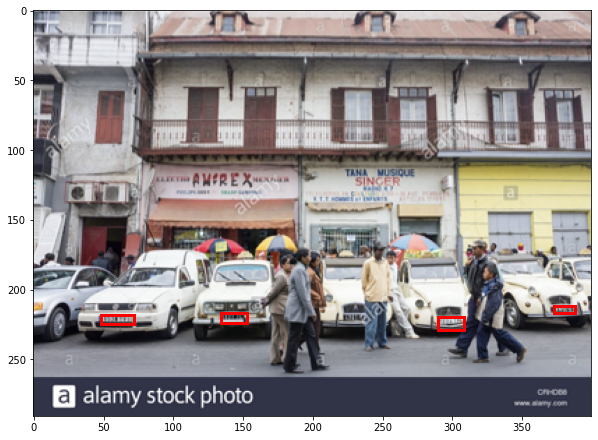

In [25]:
# Open the annotation file and read the contents
with open(os.path.join(TRAIN_LABELS_PATH, 'Cars277.txt')) as f:
    txt_example = f.read()
# Display the content on the screen
print(txt_example)
# Let's look at what the picture itself looks like
plot_bounding_box(TRAIN_IMAGES_PATH, 'Cars277.png', df)

#Training a model

** Model architecture selection: **

You can select a pre-trained YOLOv4 or YOLOv5 model for object detection and fine-tune it for number plate detection. You can download the pre-trained models and their configuration files from the official YOLO website.

In [26]:
#Check that the number of annotations matches the number of images in each sample
print(len(os.listdir(TRAIN_LABELS_PATH)) == len(os.listdir(TRAIN_IMAGES_PATH)))
print(len(os.listdir(VAL_LABELS_PATH)) == len(os.listdir(VAL_IMAGES_PATH)))

True
True


In [27]:
!pip install cvxpy==1.1.10

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for cvxpy: filename=cvxpy-1.1.10-cp38-cp38-linux_x86_64.whl size=3717761 sha256=e0b08597b33672e0d45d94ea60f1175d93a2fd6fe7e73f34f5c80a32a6040ea6
  Stored in directory: /root/.cache/pip/wheels/c7/ff/56/5829fba371225804f9b27e9914afdddaf37830bba617788dea
Successfully built cvxpy
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.2.3
    Uninstalling cvxpy-1.2.3:
      Successfully uninstalled cvxpy-1.2.3


In [28]:
# Clone the repository with the YOLO-v5 model
!git clone https://github.com/ultralytics/yolov5
# Set the dependencies needed for the model to work
!pip install -qr yolov5/requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 15287, done.
remote: Total 15287 (delta 0), reused 0 (delta 0), pack-reused 15287
Receiving objects: 100% (15287/15287), 14.12 MiB | 16.39 MiB/s, done.
Resolving deltas: 100% (10490/10490), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.


As a result of cloning, a yolov5 folder will appear in our working directory (/car_number_plate/) with a copy of the code for creating and training the model. Let's look at the contents of the yolov5 folder to make sure everything went well:

In [29]:
!ls

dataset  drive	sample_data  yolov5


In [30]:
!ls yolov5

benchmarks.py	 data	     LICENSE	      requirements.txt	tutorial.ipynb
CITATION.cff	 detect.py   models	      segment		utils
classify	 export.py   README.md	      setup.cfg		val.py
CONTRIBUTING.md  hubconf.py  README.zh-CN.md  train.py


In [31]:
import os
# Move to the directory yolov5
os.chdir('yolov5')
# Import init_seeds function from there
from utils.general import init_seeds
#Fix a random number generator to reproduce the results
RANDOM_STATE = 42
init_seeds(RANDOM_STATE)
# go back to the working directory
os.chdir('../')

During the training of the YOLOv5 model, the implementation from Ultralitics uses the Weights&Bias (W&B) tool to save the training process. [Weights&Bias](https://docs.wandb.ai/) is a machine learning platform that allows developers to build better models faster and track their qualities. It allows you to use lightweight, interoperable W&B tools for quickly tracking experiments, versifying and iterating datasets, evaluating model performance, reproducing models, visualizing results and identifying regressions, and sharing results with colleagues.

In [32]:
!pip install -q wandb --upgrade

import wandb
wandb.login(anonymous='must')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 66.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 20.7 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [33]:
#wandb login --relogin

We can now use the model and retrain it for our task on a given dataset.

### Training the model

The train.py script is used to train the model in the yolov5 repository. To run it, you must specify the following keys:

* `--img` - the size of the image supplied to the YOLOv5 input. This means that the size of the original image is converted to the form $n x n$, where $n$ is the number entered by the user after the -img key;

    **Important:**
    $n$ must be a multiple of 32 (this is due to the YOLOv5 architecture). 32 in this case is the size of one segment, which we talked about when we discussed the general idea of ​​YOLO.
* `--batch` - batch size, that is, the number of images fed to the network in one training step;
* `--epochs` - the number of training epochs, sets how many times the dataset will be passed through the neural network to train it;
* `--data` is the path to the .yaml file that we created above;
* `--weights` - pre-trained weights used by the model;
* `--name` - the name of the folder where we save the learning results.

The `--weights` key is responsible for choosing a pre-trained model.

In practice, we almost always use a model pre-trained on another dataset and adapt it to our task. In particular, the YOLOv5 model is pre-trained on the popular COCO dataset, which you can read about [here](https://cocodataset.org/#home). This is a dataset that uses 80 different classes from humans and dogs to airplanes and cars.

Of course, our (vehicle license plate) will not be found among these classes, however, we can use the patterns and templates learned during training on the COCO dataset and adapt them to our task. This approach is called **Transfer Learning**.


Let's start training:

In [34]:
# Run the train.py file with the script to train the model

!python yolov5/train.py \
--img 640 \
--batch 10 \
--epochs 30 \
--data {DATA_CONFIG_PATH} \
--weights yolov5s.pt \
--name my_yolov5_model_s

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Currently logged in as: anony-moose-507751. Use `wandb login --relogin` to force relogin
train: weights=yolov5s.pt, cfg=, data=dataset/dataset.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=10, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=my_yolov5_model_s, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-116-g5c91dae Python-3.8.10 torch-1.13.1+c

**Note:**
*Please note that all training results are saved in runs/train/directories as the number of runs increases. That is, the results of the first run will be saved in the directory `my_yolov5_model_s`, the second in the directory `my_yolov5_model_s2`, the third in `my_yolov5_model_s3`, etc. Be careful when you start training several times in a row!

[link text](https://)#### Validate the model

When the model finishes its training, the console will indicate where the final results will be saved.

In [35]:
!ls yolov5/runs/train/my_yolov5_model_s/

confusion_matrix.png				    results.png
events.out.tfevents.1678081485.943ca74ef3fe.4206.0  train_batch0.jpg
F1_curve.png					    train_batch1.jpg
hyp.yaml					    train_batch2.jpg
labels_correlogram.jpg				    val_batch0_labels.jpg
labels.jpg					    val_batch0_pred.jpg
opt.yaml					    val_batch1_labels.jpg
P_curve.png					    val_batch1_pred.jpg
PR_curve.png					    val_batch2_labels.jpg
R_curve.png					    val_batch2_pred.jpg
results.csv					    weights


[link text](https://)Let's look at the graphs, the most general information of interest to us is contained in the file results.png.

The runs/result/weights folder contains 2 files with weights (neural network parameters):
* best.pt - the file with the best variant of the model's parameters for the whole training period
* last.pt - the file where weights obtained by the model at the last epoch of training are saved


**Note:**

*The best model is not always (almost never) the last one!

In [36]:
!ls yolov5/runs/train/my_yolov5_model_s/weights

best.pt  last.pt


Let's load the best weights into our model. 

To do this, the hub module of the pytorch library has the load() function. This function allows PyTorch to automatically load models from repositories on GitHub or from local directories and "populate" them with parameter values from files:
* repo_or_dir is the path to the directory and repository where the model is stored. In our case this is the directory where the repository is stored - yolov5;
* model - model name. In YOLOv5, all custom models are referred to as 'custom';
* path - the path to the model weights. Specify the path to the file best.pt; 
* source - source, can be 'local' if the model is taken from local directory or 'github' if the model is downloaded from github. 
    We have everything already uploaded to the working folder, so we put 'local'.

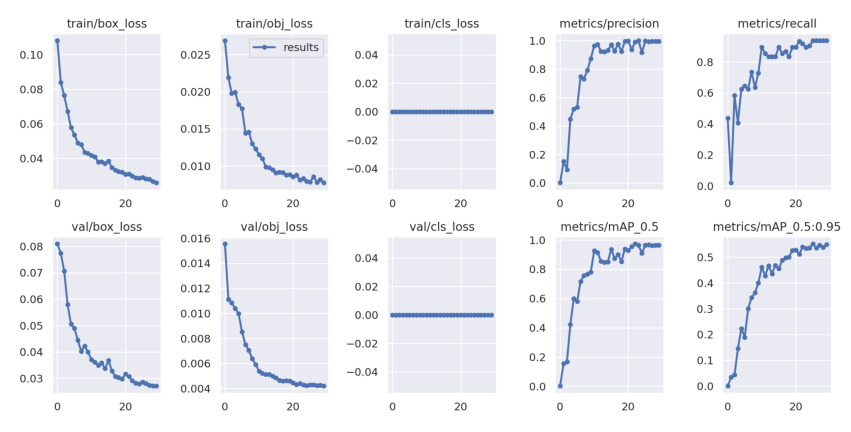

In [37]:
# Читаем файл с графиками процесса обучения
results = plt.imread('yolov5/runs/train/my_yolov5_model_s/results.png')
# Отображаем графики
fig, ax = plt.subplots(figsize=(15,12))
ax.axis('off')
ax.imshow(results);


In [38]:
!ls yolov5/runs/train/my_yolov5_model_s/weights


best.pt  last.pt


In [39]:
BEST_WEIGHTS_PATH = 'yolov5/runs/train/my_yolov5_model_s/weights/best.pt'
# Uploading the best
yolov5 = torch.hub.load(
    repo_or_dir='yolov5',
    model='custom',
    path=BEST_WEIGHTS_PATH,
    source='local'
)


requirements: YOLOv5 requirement "setuptools>=65.5.1" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

requirements: 1 package updated per /content/yolov5/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 v7.0-116-g5c91dae Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


Let's check how our best model works by taking some picture and feeding it to the input of the model. To do this, just use the yolov5 object as a function, passing the path to the file as its parameter. We can display the result right away, just call the show() method:

The number next to the class name is called confidence. **Confidence** is measured from 0 to 1 and characterizes the "confidence" of the model that this object is an object of a certain class. In other words, it is the probability that a given bounding box contains an object of the specified class.

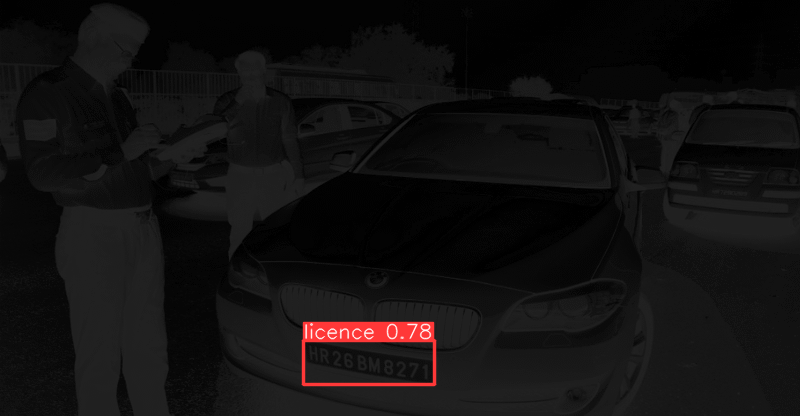

In [41]:
# Path to the image
image_filename = '/content/drive/MyDrive/Colab Notebooks/cars_number_plate/test.png'
image_path = os.path.join(IMAGES_PATH, image_filename)
# Passing the picture through the model
prediction = yolov5(image_filename)
# Displaying the result
prediction.show()

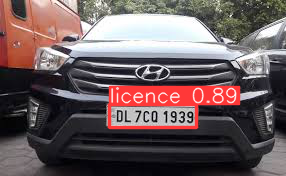

In [53]:
# Path to the image
image_filename = '/content/drive/MyDrive/Colab Notebooks/cars_number_plate/images.png'
image_path = os.path.join(IMAGES_PATH, image_filename)
# Passing the picture through the model
prediction = yolov5(image_filename)
# Displaying the result
prediction.show()

The resulting result is quite easy to convert to a DataFrame, for this YOLOv5 provides functionality in the form of the pandas() method:

In [42]:
# Path to the image
image_filename = 'Cars352.png'
image_path = os.path.join(IMAGES_PATH, image_filename)
# Passing the picture through the model
prediction = yolov5(image_path)
# # Converting the result to a DataFrame:
prediction.pandas().xyxy[0]

,xmin,ymin,xmax,ymax,confidence,class,name
0,77.273399,181.941956,93.968803,189.937866,0.707342,0,licence
1,200.741455,185.593704,216.650772,194.179291,0.460205,0,licence


> **Note:**

It is important to note that we can independently cut off such bounding boxes whose confidence is less than a certain constant (confidence_rate), thereby affecting the final precision and recall metrics of our model in production.

For example, if we need to recognize as many (recall) license plates as possible and we are not so afraid of false positives (for example, when monitoring traffic on the roads), then we can take a low level of trust. Thus, we increase recall.

If we need to determine license plates as accurately as possible (precision), ignoring noise, (for example, in paid parking lots), then we will increase the confidence threshold.

As we know, for an ideal model, both precision and recall are equal to 1, but there are no ideal models. Finding the optimal threshold of trust for your task is a separate problem, the solution of which is individual for each specific system.

According to the obtained coordinates, you can manually cut out images with license plates from the original ones. However, even here the YOLOv5 developers took care of it for us.

The model supports the built-in crop() method. This method returns a list of dictionaries, each dictionary is characterized separately by a bounding box - its coordinates (the "box" key), the level of trust (the "confidence" key), the class number of the object (the "class" key), the name of the class (the "label" key) and the actual cut image itself (the "im").

Let's see an example of a clipping. We will cut off such clippings, the credibility of which is < 0.7:

In [43]:
!pip install easyocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 75.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.2/619.2 KB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 18.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.7.0.72
    Uninstalling opencv-python-headless-4.7.0.72:
      Successfully uninstalled opencv-python-headless-4.7.0.72


Saved 1 image to runs/detect/exp5
Saved results to runs/detect/exp5



AxesImage(54,36;334.8x217.44)


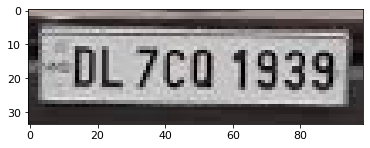

In [54]:
#importing the library
import easyocr
from PIL import Image
car_number=[]
# Path to image
image_filename = '/content/drive/MyDrive/Colab Notebooks/cars_number_plate/images.png'
image_path = os.path.join(IMAGES_PATH, image_filename)
# Pass the picture through the model
prediction = yolov5(image_path)
# Making clippings from an image
croped = prediction.crop()
# Creating a loop for each clipping
for pred in croped:
    # we cut off the bounding boxes trusted < 0.7
    if pred['conf'] < 0.7:
        continue
    # Retrieve the cropped out image
    img_croped = pred['im']
    # visualize the result
    fig = plt.figure()
    print(plt.imshow(img_croped))
    reader = easyocr.Reader(['en'])

    # Use EasyOCR to extract text from the image
    results = reader.readtext(img_croped)
    # Print the extracted text
    for result in results:
        car_number.append(result[1])


In [55]:
print(car_number)

['DL 7CO 1939']
